In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
from collections import OrderedDict
import re
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [26]:
from plot_checkpoints import *

In [32]:
from tqdm.notebook import tqdm

In [33]:
from plot_checkpoints import sample_langevin_cuda_tqdm

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['figure.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['legend.facecolor'] = (50/256, 50/256, 50/256)
mpl.rcParams['savefig.facecolor'] = (27/256, 27/256, 27/256)
data_color = (0.2, 0.7, 1.0, 1.0)
samp_color = (1.0, 0.7, 0.1, 0.6)
aux_color =(0, 0.9, 0.0, 0.6)

In [5]:
# mpl.rcdefaults()

In [6]:
device = torch.device('cuda:0')

In [7]:
torch.cuda.get_device_name(torch.device('cuda:0'))

'NVIDIA GeForce RTX 2070 SUPER'

In [ ]:
sys.path.remove('/home/phil/Desktop/EBMs/lapd-ebm') # Remove this script directory path

In [73]:
experiments_dir = "/home/phil/Desktop/EBMs/lapd-ebm/experiments_modular"
# filepaths = [
#              '2022-08-23_14h-16m-39s/checkpoints/model-0-13225.pt'
#              ]

f = '2022-08-23_14h-16m-39s/checkpoints/model-0-13225.pt'

pattern = re.compile(r"(\d{4}-\d{2}-\d{2}_\d{2}h-\d{2}m-\d{2}s)\/checkpoints\/(model-\d+-\d+.pt)")
match = re.search(pattern, f)
identifier = match.group(1)
rundir = experiments_dir + "/" + identifier
model_num = match.group(2)

with open(rundir + "/" + "modular_ebm_copy.py", 'r') as infile:
    for line in infile:
        if "data_path = " in line:
            data_filename = (line[17:-6])
        if "\"step_size\": " in line:
            step_size = float(line[21:-2])
        if "\"sample_steps\": " in line:
            sample_steps = int(line[24:-2])
        if "\"noise_scale\": " in line:
            noise_scale = float(line[23:-2])


# ------ Load model ------ #
print("Loading model " + identifier + " " + model_num + ". ")

# Add path for import the correct diagnostic and sampling modules
sys.path.insert(0, os.path.join(experiments_dir, identifier))

spec = importlib.util.spec_from_file_location("modular_ebm_copy", rundir + "/modular_ebm_copy.py")
ebm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ebm)
sample_langevin = ebm.sample_langevin
sample_langevin_cuda = ebm.sample_langevin_cuda
ReplayBuffer = ebm.ReplayBuffer
try:
    perturb_samples = ebm.perturb_samples
except:
    def perturb_samples(x):
        return x

model = ebm.ModularWithRNNBackbone().to(device)
ckpt = torch.load("experiments_modular/" + f)

model_dict = OrderedDict()
pattern = re.compile('module.')
state_dict = ckpt['model_state_dict']
for k, v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict = state_dict
model.load_state_dict(model_dict, strict=True)

# ------ Load data ------ #

# data_all = np.load(data_filename + ".npz")['signals']
if 'train' in data_filename:
    data_filename = data_filename[:-6]
data_valid = ebm.load_data(data_filename + "-valid.npz")

data_path = data_filename + "-valid.npz"
data = ebm.load_data(data_path)
mean = np.zeros((10))
ptp = np.load(data_path)['scale']
datasize = data.shape[1]



#         data_valid_idx = 50123
#         if 'replay_buffer_list' in list(ckpt.keys()):
#             buff_samps = ckpt['replay_buffer_list'].detach().cpu().numpy()
#             print(buff_samps.shape)
#             print("Plotting replay buffer...")
#             plot_all_msi(buff_samps, data_valid, data_valid_idx, ptp)
#             plt.savefig("experiments_modular/" + identifier + "/plots/buffer_traces-" + model_num + ".png")
#             plot_energy_histogram(data, buff_samps, buff_samps.shape[0] // 8, 8)
#             plt.savefig("experiments_modular/" + identifier + "/plots/buffer_energies-" + model_num + ".png")
#             plot_diagnostics_histogram(buff_samps, data, ptp)
#             plt.savefig("experiments_modular/" + identifier + "/plots/buffer_hist-" + model_num + ".png")

print("Number of parameters: {}. ".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))


Loading model 2022-08-23_14h-16m-39s model-0-13225.pt. 
Number of parameters: 45093537. 


In [74]:
n_samp_total = 32
n_samp_divis = 1
n_samp = n_samp_total // n_samp_divis

In [75]:
def plot_all_msi(data_samps, data_valid, data_valid_idx, ptp):
    data_sub_samps = data_samps[:]
    data_samps_mean = np.mean(data_sub_samps, axis=0)
    # data_samps_std = np.std(data_sub_samps, axis=0)

    fig, axes = plt.subplots(5, 2, figsize=(8, 7), dpi=150)

    for ax in axes.flatten():
        ax.set_autoscale_on(False)

    for i in range(data_samps.shape[0]):
        axes[0, 0].plot(xrange, data_samps[i, 32 * 0:32 * 1] * ptp['discharge_current'], color=colors[-1], label="Sampled")
        axes[0, 1].plot(xrange, data_samps[i, 32 * 1:32 * 2] * ptp['discharge_voltage'], color=colors[-1])
        axes[1, 0].plot(xrange, data_samps[i, 32 * 2:32 * 3] * ptp['interferometer'], color=colors[-1])
        axes[1, 1].plot(xrange, data_samps[i, 32 * 3:32 * 4] * ptp['diode_0'], color=colors[-1])
        axes[2, 0].plot(xrange, data_samps[i, 32 * 4:32 * 5] * ptp['diode_1'], color=colors[-1])
        axes[2, 1].plot(xrange, data_samps[i, 32 * 5:32 * 6] * ptp['diode_2'], color=colors[-1])
        axes[3, 0].plot(xrange, data_samps[i, 32 * 6:32 * 7] * ptp['diode_3'], color=colors[-1])
        axes[3, 1].plot(xrange, data_samps[i, 32 * 7:32 * 8] * ptp['diode_4'], color=colors[-1])
        axes[4, 0].plot(B_xrange, data_samps[i, 32 * 8:32 * 8 + 64] * ptp['magnet_profile'], color=colors[-1])
        axes[4, 1].scatter(np.arange(51), data_samps[i, 32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures'], color=colors[-1])

    for ax in axes.flatten():
        ax.set_autoscale_on(True)

    axes[0, 0].plot(xrange, data_samps_mean[32 * 0:32 * 1] * ptp['discharge_current'], color=colors[4], label="Sampled mean")
    axes[0, 1].plot(xrange, data_samps_mean[32 * 1:32 * 2] * ptp['discharge_voltage'], color=colors[4])
    axes[1, 0].plot(xrange, data_samps_mean[32 * 2:32 * 3] * ptp['interferometer'], color=colors[4])
    axes[1, 1].plot(xrange, data_samps_mean[32 * 3:32 * 4] * ptp['diode_0'], color=colors[4])
    axes[2, 0].plot(xrange, data_samps_mean[32 * 4:32 * 5] * ptp['diode_1'], color=colors[4])
    axes[2, 1].plot(xrange, data_samps_mean[32 * 5:32 * 6] * ptp['diode_2'], color=colors[4])
    axes[3, 0].plot(xrange, data_samps_mean[32 * 6:32 * 7] * ptp['diode_3'], color=colors[4])
    axes[3, 1].plot(xrange, data_samps_mean[32 * 7:32 * 8] * ptp['diode_4'], color=colors[4])
    axes[4, 0].plot(B_xrange, data_samps_mean[32 * 8:32 * 8 + 64] * ptp['magnet_profile'], color=colors[4])
    axes[4, 1].scatter(np.arange(51), data_samps_mean[32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures'], color=colors[4])

    axes[0, 0].plot(xrange, data_valid[data_valid_idx, 32 * 0:32 * 1] * ptp['discharge_current'], color=colors[0])
    axes[0, 1].plot(xrange, data_valid[data_valid_idx, 32 * 1:32 * 2] * ptp['discharge_voltage'], color=colors[0])
    axes[1, 0].plot(xrange, data_valid[data_valid_idx, 32 * 2:32 * 3] * ptp['interferometer'], color=colors[0])
    axes[1, 1].plot(xrange, data_valid[data_valid_idx, 32 * 3:32 * 4] * ptp['diode_0'], color=colors[0])
    axes[2, 0].plot(xrange, data_valid[data_valid_idx, 32 * 4:32 * 5] * ptp['diode_1'], color=colors[0])
    axes[2, 1].plot(xrange, data_valid[data_valid_idx, 32 * 5:32 * 6] * ptp['diode_2'], color=colors[0])
    axes[3, 0].plot(xrange, data_valid[data_valid_idx, 32 * 6:32 * 7] * ptp['diode_3'], color=colors[0])
    axes[3, 1].plot(xrange, data_valid[data_valid_idx, 32 * 7:32 * 8] * ptp['diode_4'], color=colors[0])
    axes[4, 0].plot(B_xrange, data_valid[data_valid_idx, 32 * 8:32 * 8 + 64] * ptp['magnet_profile'], color=colors[0])
    axes[4, 1].scatter(np.arange(51), data_valid[data_valid_idx, 32 * 8 + 64:32 * 8 + 64 + 51] * ptp['pressures'], color=colors[0])

    axes[0, 0].set_title('Discharge I (Amps) vs ms')
    axes[0, 1].set_title('Discharge V vs ms')
    axes[1, 0].set_title('Interferometer (Volts) vs ms')
    axes[1, 1].set_title('Diode 0 (Volts) vs ms')
    axes[2, 0].set_title('Diode 1 (Volts) vs ms')
    axes[2, 1].set_title('Diode 2 (Volts) vs ms')
    axes[3, 0].set_title('Diode 3 (Volts) vs ms')
    axes[3, 1].set_title('Diode 4 (HeII) (Volts) vs ms')
    axes[4, 0].set_title('Magnet field profile (G) vs cm')
    axes[4, 1].set_title('log(RGA) (Torr)')
    plt.suptitle("Real discharges = red, conditionally sampled = blue")
    plt.tight_layout()

In [76]:
def conditionally_sample(init_data, n_samp, steps, step_size, noise, conditional_mask, includes_flags=True):
    data_samps = init_data.clone()
    data_samps = (1 - conditional_mask) * data_samps
    data_samps += (torch.rand((n_samp, data_samps.shape[1]), requires_grad=True).to(device) * 2 - 1) * (conditional_mask)
    
    for i in tqdm(range(6)):
        # if includes_flags:
        #     data_samps[:, samp_begin:samp_end - 10] = perturb_samples(data_samps[:, samp_begin:samp_end - 10])
        # else:
        #     data_samps[:, samp_begin:samp_end] = perturb_samples(data_samps[:, samp_begin:samp_end])
        data_samps = sample_langevin_cuda_tqdm(data_samps, model, step_size=step_size, sample_steps=steps,
                                               noise_scale=noise, conditional_mask=conditional_mask)
    data_samps = data_samps.to('cpu').detach().numpy()

    # torch.cuda.empty_cache()
    return data_samps

In [77]:
dischargeI_mask = torch.zeros((1, 32))
dischargeV_mask = torch.cat([torch.zeros((1, 7)), torch.ones((1, 4)), torch.zeros((1, 21))], dim=1)
interferometer_mask = torch.zeros((1, 32))
diode0_mask = torch.zeros((1, 32))
diode1_mask = torch.zeros((1, 32))
diode2_mask = torch.zeros((1, 32))
diode3_mask = torch.zeros((1, 32))
diode4_mask = torch.zeros((1, 32))
magnetic_mask = torch.ones((1, 64))
gas_mask = torch.cat([torch.zeros((1, 2)), torch.ones((1, 1)), torch.zeros((1, 48))], dim=1)
flags = torch.zeros((1, 10))
conditional_mask = 1-torch.cat([dischargeI_mask, dischargeV_mask, interferometer_mask, 
                              diode0_mask, diode1_mask, diode2_mask, diode3_mask, diode4_mask, magnetic_mask, gas_mask, flags], dim=1).to(device)

In [78]:
steps = sample_steps * 2
step_size = step_size
noise = noise_scale

data_valid_idx = 50123

init_data = data_valid[data_valid_idx].clone().detach().repeat((n_samp, 1)).to(device)
data_samps = []
for i in range(n_samp_divis):
    data_samps.append(conditionally_sample(init_data, n_samp, steps, step_size, noise, conditional_mask, includes_flags=True))
data_samps = np.concatenate(data_samps, 0)

  0%|          | 0/6 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]

 14%|█████████████▌                                                                                   | 14/100 [00:02<00:16,  5.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]

 29%|████████████████████████████▏                                                                    | 29/100 [00:05<00:13,  5.14it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]

 44%|██████████████████████████████████████████▋                                                      | 44/100 [00:08<00:11,  5.08it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]

 59%|█████████████████████████████████████████████████████████▏                                       | 59/100 [00:11<00:08,  5.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.05it/s]

 74%|███████████████████████████████████████████████████████████████████████▊                         | 74/100 [00:14<00:05,  5.02it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.03it/s]


<IPython.core.display.Javascript object>


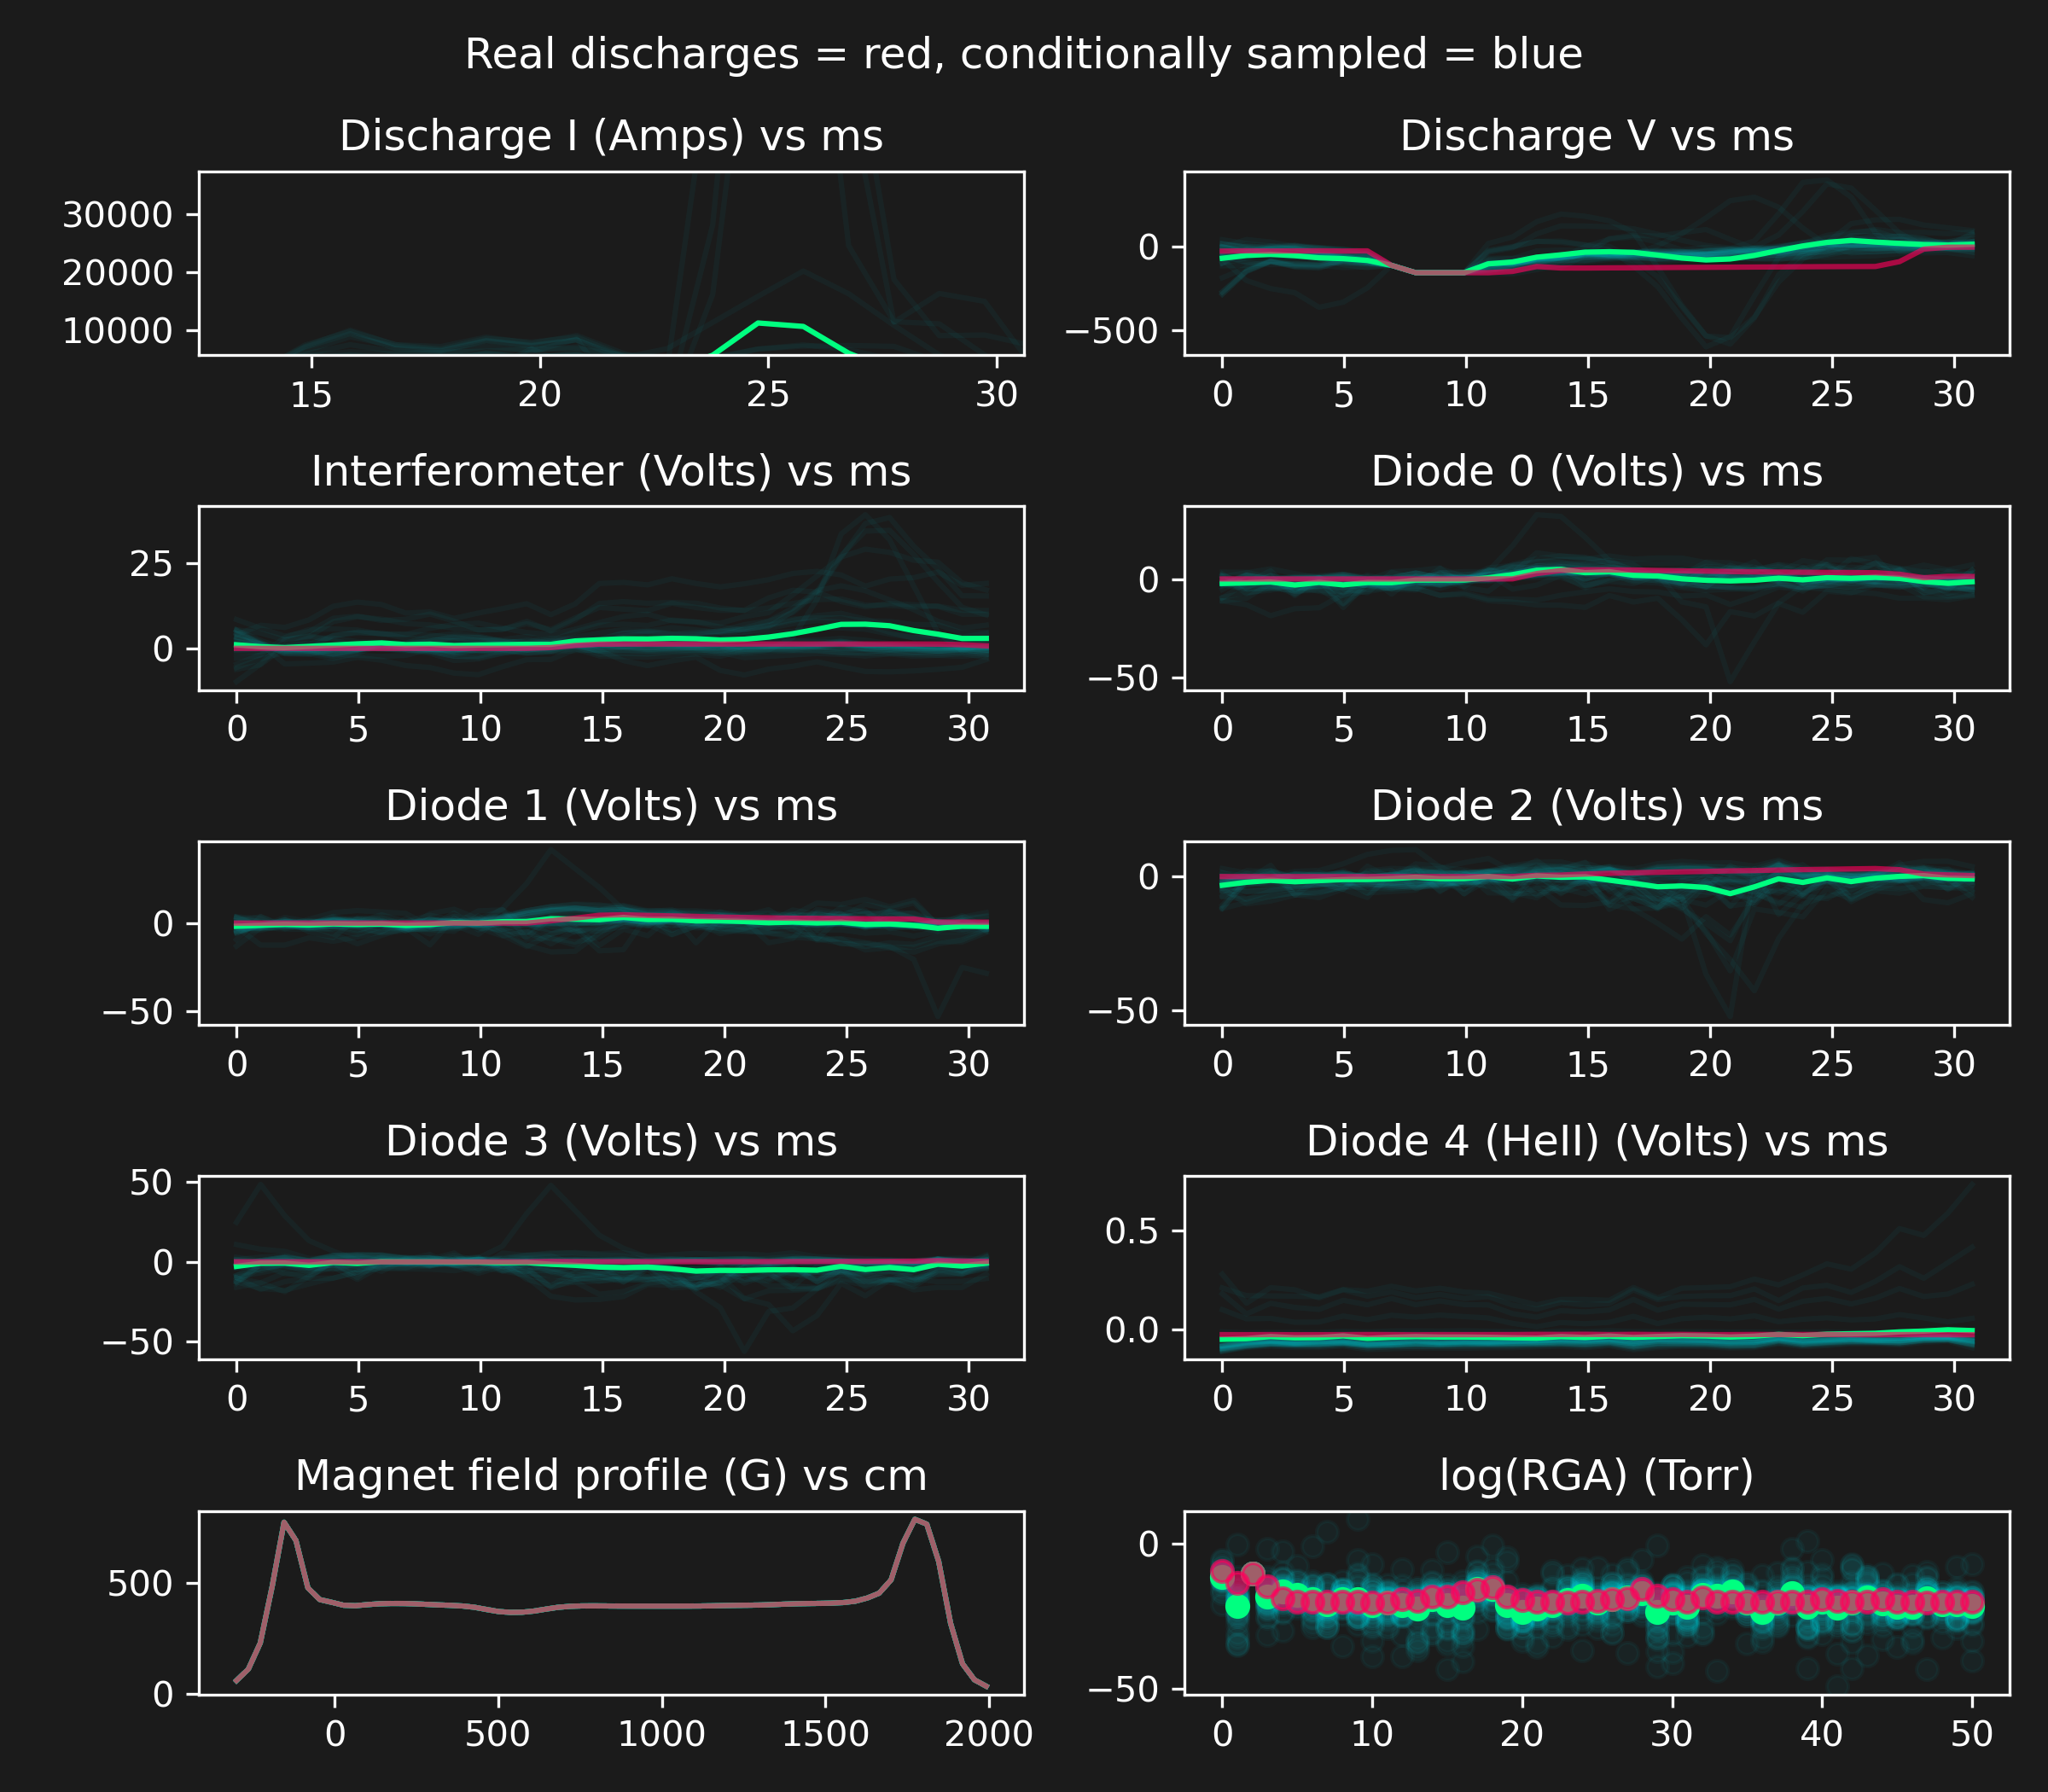

In [79]:
plot_all_msi(data_samps, data_valid, data_valid_idx, ptp)